In [1]:
import json
import logging
import re
import time
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import watchdog.events
from matplotlib.backends.backend_pdf import PdfPages
from simple_salesforce import Salesforce
from slack_sdk import WebClient
from slack_sdk.errors import SlackApiError
from watchdog.observers.polling import PollingObserver as Observer

In [2]:
channel='#testing'

### Salesforce ###
def sf_login():
    logininfo = json.load(open('/ghds/groups/labdesk/bshih/salesforce_login.json'))

    username = logininfo['username']
    password = logininfo['password']
    security_token = logininfo['security_token']

    return Salesforce(username=username, password=password, security_token=security_token)

### Slack ###
def slack_login():
    slack_token = json.load(open('/ghds/groups/labdesk/bshih/slack_login.json'))['SLACK_TOKEN']
    return WebClient(token=slack_token)

def sample_finder(all_samples):
    """
    :param all_samples:
    :return: Filtered dataframe with samples whose RNAse <= 50 and G19 >= 0.01, singlicates.
    """
    samples = all_samples[all_samples['run_sample_id'].str.startswith(('G', 'H'), na=False)]
    samples = samples[~samples['run_sample_id'].str.startswith('Ht', na=False)]
    filtered = samples.groupby('run_sample_id').filter(
        lambda x: (x['rnase_count'].median() <= 50) & (x['covid_ratio'].median() >= 0.01))

    return filtered

def salesforce_query(samples, sf):
    weird_samples = []
    accession = []
    for i in samples['run_sample_id'].unique():
        weird_samples.extend(sf.query_all(f"SELECT GH_Sample_ID__c, Status, Specimen_Collection_Date_Time__c, Specimen_receipt_date__c,\
                  State_Authorities_Notified_Date__c, Site_Name__c \
                  FROM Order WHERE GH_Sample_ID__c = '{i}'").get('records'))

        accession.extend(sf.query_all(f"SELECT Specimen_Id__c, Accessioning_Verified_Date__c FROM Specimen__c\
                                        WHERE Specimen_Id__c = '{i}'").get('records'))

    dataframe = pd.DataFrame(weird_samples)
    df = dataframe.drop(columns='attributes').rename(columns={'GH_Sample_ID__c': 'run_sample_id',
                                                              'Specimen_Collection_Date_Time__c': 'Specimen Collection Date/Time',
                                                              'State_Authorities_Notified_Date__c': 'State Authorities Notified Date',
                                                              'Site_Name__c': 'Site Name'})
    df['Specimen Collection Date/Time'] = pd.to_datetime(df['Specimen Collection Date/Time']).dt \
        .tz_convert('US/Pacific').dt.strftime('%-m/%-d/%Y, %-I:%M %p')
    try:
        df['State Authorities Notified Date'] = pd.to_datetime(df['State Authorities Notified Date']).dt \
            .tz_convert('US/Pacific').dt.strftime('%-m/%-d/%Y, %-I:%M %p')
    except TypeError:
        pass

    dataframe2 = pd.DataFrame(accession)
    df2 = dataframe2.drop(columns='attributes').rename(columns={'Specimen_Id__c': 'run_sample_id',
                                                                'Accessioning_Verified_Date__c': 'accession_date'})

    df2['accession_date'] = pd.to_datetime(df2['accession_date']).dt \
        .tz_convert('US/Pacific').dt.strftime('%-m/%-d/%Y, %-I:%M %p')

    df = df.merge(df2, left_on='run_sample_id', right_on='run_sample_id', how='left')

    return df

def merge_sample_salesforce(samples, salesforce_data):
    """
    :param samples:
    :param salesforce_data:
    :return: Merged dataframe samples with salesforce data
    """
    df = pd.merge(samples, salesforce_data, left_on='run_sample_id', right_on='run_sample_id', how='left').loc[:,
         ['runid',
          'run_sample_id',
          'covid_ratio',
          'covid_count',
          'rnase_count',
          'spikein_count',
          'replicate_call',
          'replicate_flags',
          'Specimen Collection Date/Time',
          'accession_date',
          'State Authorities Notified Date',
          'Site Name']] \
        .sort_values(by=['runid', 'run_sample_id', 'covid_ratio'], ascending=[False, True, True])

    median_scores = df.groupby('run_sample_id').median().rename(columns={'covid_ratio': 'new_median'})[
        ['new_median']].round(2)
    df = pd.merge(df, median_scores, left_on='run_sample_id', right_on='run_sample_id', how='left')
    median = df.pop('new_median')
    df.insert(2, 'new_median', median)

    df['group'] = (df['run_sample_id'].shift() != df['run_sample_id']).cumsum()
    df.loc[df.duplicated('group'), ['runid', 'run_sample_id', 'new_median', 'Specimen Collection Date/Time',
                                    'accession_date', 'State Authorities Notified Date', 'Site Name',
                                    'new_median']] = ''
    df.drop(columns=['group'], inplace=True)

    df = df.astype({'covid_count': 'int', 'rnase_count': 'int', 'spikein_count': 'int'}).round({'covid_ratio': 2})
    return df

def create_pdf(samples, file_name):
    fig, ax = plt.subplots(figsize=(35, len(samples) // 2))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=samples.values, colLabels=samples.columns, loc='center', rowLoc='right',
                         bbox=[0, 0, 1, 1])

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(12)

    for i in range(0, len(samples.columns)):
        [the_table[(j + k, i)].set_facecolor("#e0e0e0") for j in range(4, len(samples), 6) for k in range(3)]

    the_table.auto_set_column_width(col=list(range(len(samples.columns))))

    pp = PdfPages(f"/ghds/groups/labdesk/bshih/clinical_observation/{file_name}.pdf")
    pp.savefig(fig, bbox_inches='tight', dpi=300)
    pp.close()

def slack_upload(fcid, file_name, client):
    filepath = f'/ghds/groups/labdesk/bshih/clinical_observation/{file_name}.pdf'

    try:
        result = client.files_upload(
            channels=channel,
            file=filepath,
            initial_comment=f"{fcid}: These samples have RNAse Count <= 50 and G19 Score >= 0.01")
        assert result["file"]
        print('File Successfully Uploaded to Slack!')
    except SlackApiError as e:
        # You will get a SlackApiError if "ok" is False
        assert e.response["ok"] is False
        assert e.response["error"]  # str like 'invalid_auth', 'channel_not_found'
        print(f"Got an error: {e.response['error']}")

File Successfully Uploaded to Slack!


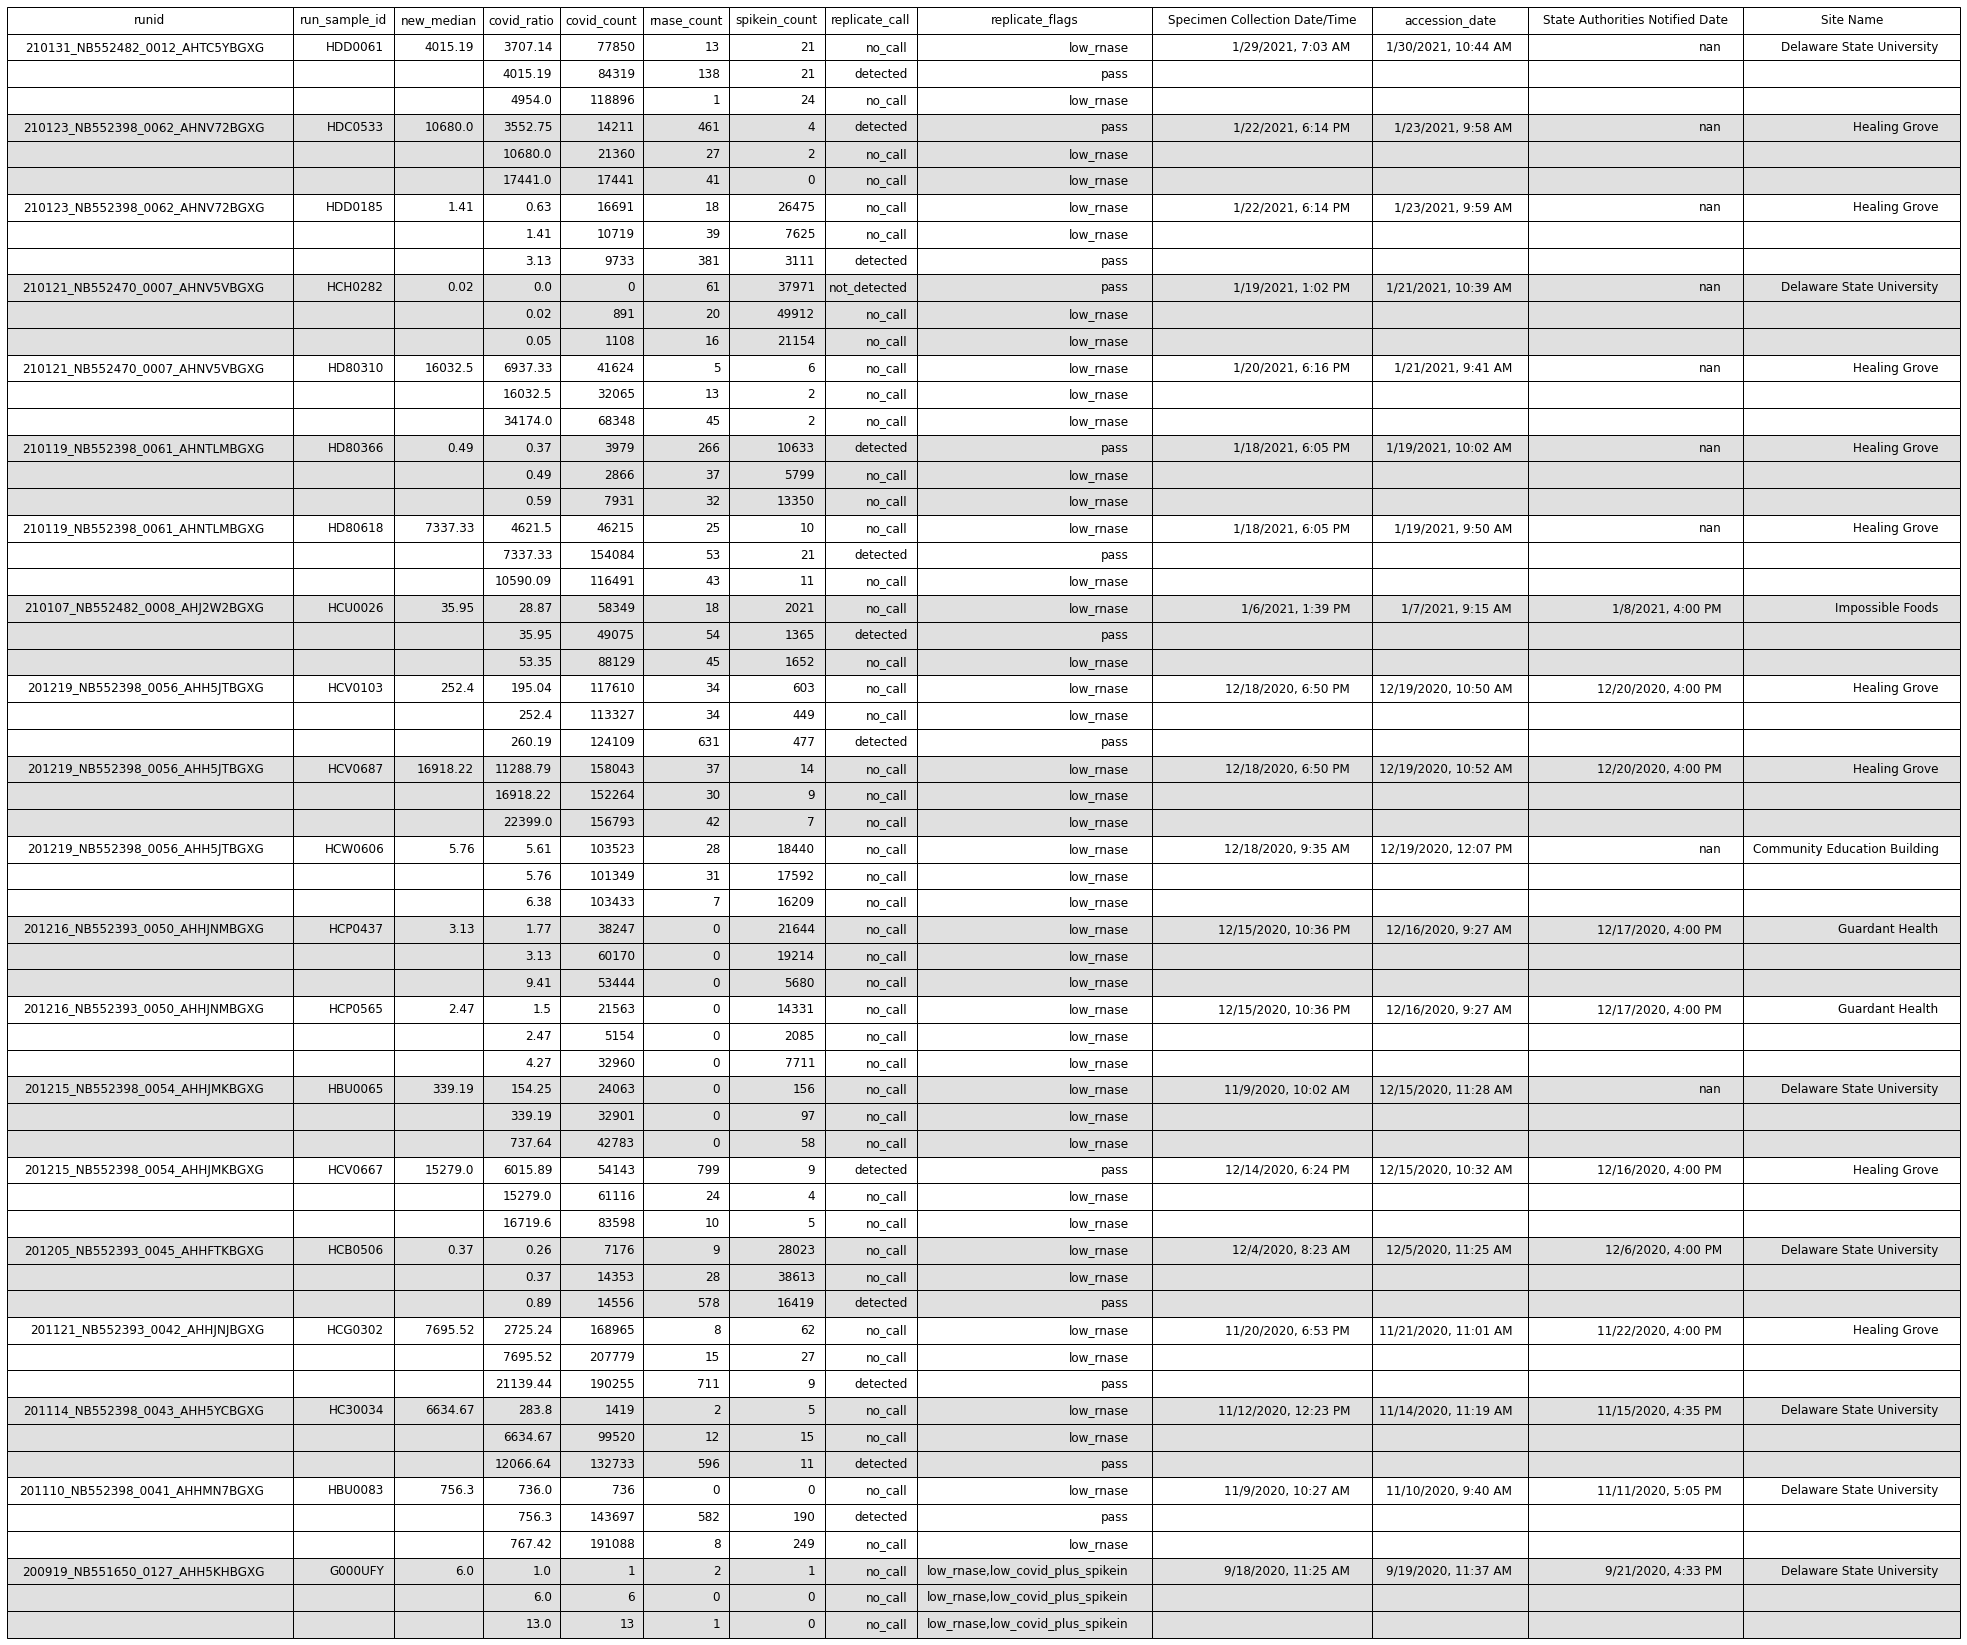

In [3]:
sf = sf_login()
client = slack_login()

all_samples_singlicate = pd.read_pickle('/ghds/groups/labdesk/bshih/c19dash/c19_dashboard/c19_read_counts.pickle')
all_samples = sample_finder(all_samples_singlicate)
salesforce_data = salesforce_query(all_samples, sf)
blah = merge_sample_salesforce(all_samples, salesforce_data)
create_pdf(blah, 'samples_test')
slack_upload('fcid', 'samples_test', client)

# Manually Run

In [ ]:
client = slack_login()
path = '/ghds/cv19/analysis/210131_NB552482_0012_AHTC5YBGXG.7a84889c-a32d-430d-a19a-e74bd033dc5e.20210131211545/c19_read_counts.hdr.tsv'

all_samples_singlicate = pd.read_csv(path, sep='\t')
all_samples = sample_finder(all_samples_singlicate)

flowcell = path[20:51]
filename = flowcell + '_lowRNAse_COVIDpositive'

if len(all_samples) != 0:
    sf = sf_login()

    salesforce_data = salesforce_query(all_samples, sf)
    blah = merge_sample_salesforce(all_samples, salesforce_data)

    create_pdf(blah, filename)
    slack_upload(flowcell, filename, client)
    
else:
    client.chat_postMessage(channel=channel,
                            text=f'{flowcell}: No QC fail samples that are covid positive today! Have a great day :)')

# Script Testing Tools

In [ ]:
fcid = '210107_NB552482_0008_AHJ2W2BGXG'

pd.read_csv(f'/ghds/cv19/analysis/{fcid}/c19_read_counts.hdr.tsv', sep='\t').to_csv('/ghds/groups/labdesk/bshih/clinopstest/210103_NB552478_0010_AHJ3KKBGXG_alltrue_test/c19_read_counts.csv')

# TEST LOGGING

In [ ]:
import logging

LOGGER_NAME = 'clinical_observation'
LOG_FILE_DIR = '/ghds/groups/labdesk/bshih'
    
logger = logging.getLogger(LOGGER_NAME)

log_file = f"{LOG_FILE_DIR}/clinical_observation.log"
handler = logging.FileHandler(log_file)

handler.setLevel(logging.INFO)
logger.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s", datefmt='%Y-%m-%d %H:%M:%S')
handler.setFormatter(formatter)
logger.addHandler(handler)  

In [ ]:
from datetime import datetime
def main():
    logger.info(f"Program is running!")

if __name__ == "__main__":
    main()